# Introduction to Brian part 2: Synapses

If you haven't yet read part 1: Neurons, go read that now.

As before we start by importing the Brian package and setting up matplotlib for IPython:

In [1]:
from brian2 import *
%matplotlib inline

## The simplest Synapse

Once you have some neurons, the next step is to connect them up via synapses. We'll start out with doing the simplest possible type of synapse that causes an instantaneous change in a variable after a spike.

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.05s). [brian2.stateupdaters.base.method_choice]


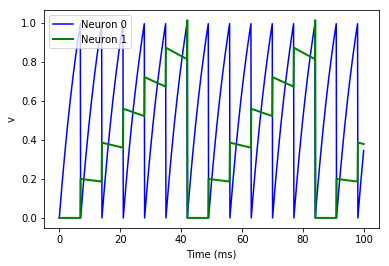

In [2]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0')
G.I = [2, 0]
G.tau = [10, 100]*ms

# # Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], '-b', label='Neuron 0')
plot(M.t/ms, M.v[1], '-g', lw=2, label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')

There are a few things going on here. First of all, let's recap what is going on with the ``NeuronGroup``. We've created two neurons, each of which has the same differential equation but different values for parameters I and tau. Neuron 0 has ``I=2`` and ``tau=10*ms`` which means that is driven to repeatedly spike at a fairly high rate. Neuron 1 has ``I=0`` and ``tau=100*ms`` which means that on its own - without the synapses - it won't spike at all (the driving current I is 0). You can prove this to yourself by commenting out the two lines that define the synapse.

Next we define the synapses: ``Synapses(source, target, ...)`` means that we are defining a synaptic model that goes from ``source`` to ``target``. In this case, the source and target are both the same, the group ``G``. The syntax ``on_pre='v_post += 0.2'`` means that when a spike occurs in the presynaptic neuron (hence ``on_pre``) it causes an instantaneous change to happen ``v_post += 0.2``. The ``_post`` means that the value of ``v`` referred to is the post-synaptic value, and it is increased by 0.2. So in total, what this model says is that whenever two neurons in G are connected by a synapse, when the source neuron fires a spike the target neuron will have its value of ``v`` increased by 0.2.

However, at this point we have only defined the synapse model, we haven't actually created any synapses. The next line ``S.connect(i=0, j=1)`` creates a synapse from neuron 0 to neuron 1.

## Adding a weight

In the previous section, we hard coded the weight of the synapse to be the value 0.2, but often we would to allow this to be different for different synapses. We do that by introducing synapse equations.

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'linear' (took 0.02s). [brian2.stateupdaters.base.method_choice]


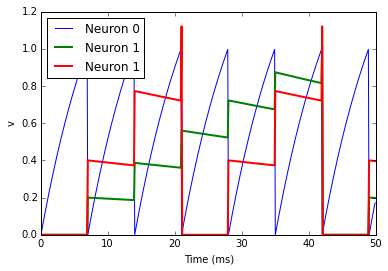

In [3]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], '-b', label='Neuron 0')
plot(M.t/ms, M.v[1], '-g', lw=2, label='Neuron 1')
plot(M.t/ms, M.v[2], '-r', lw=2, label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')

This example behaves very similarly to the previous example, but now there's a synaptic weight variable ``w``. The string ``'w : 1'`` is an equation string, precisely the same as for neurons, that defines a single dimensionless parameter ``w``. We changed the behaviour on a spike to ``on_pre='v_post += w'`` now, so that each synapse can behave differently depending on the value of ``w``. To illustrate this, we've made a third neuron which behaves precisely the same as the second neuron, and connected neuron 0 to both neurons 1 and 2. We've also set the weights via ``S.w = 'j*0.2'``. When ``i`` and ``j`` occur in the context of synapses, ``i`` refers to the source neuron index, and ``j`` to the target neuron index. So this will give a synaptic connection from 0 to 1 with weight ``0.2=0.2*1`` and from 0 to 2 with weight ``0.4=0.2*2``.

## Introducing a delay

So far, the synapses have been instantaneous, but we can also make them act with a certain delay.

INFO       No numerical integration method specified for group 'neurongroup', using method 'linear' (took 0.02s). [brian2.stateupdaters.base.method_choice]


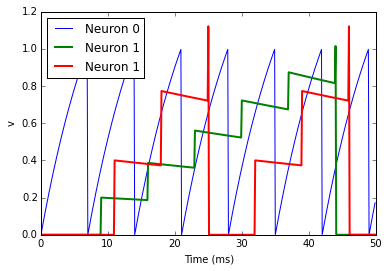

In [4]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], '-b', label='Neuron 0')
plot(M.t/ms, M.v[1], '-g', lw=2, label='Neuron 1')
plot(M.t/ms, M.v[2], '-r', lw=2, label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')

As you can see, that's as simple as adding a line ``S.delay = 'j*2*ms'`` so that the synapse from 0 to 1 has a delay of 2 ms, and from 0 to 2 has a delay of 4 ms.

## More complex connectivity

So far, we specified the synaptic connectivity explicitly, but for larger networks this isn't usually possible. For that, we usually want to specify some condition.

In [3]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

Here we've created a dummy neuron group of N neurons and a dummy synapses model that doens't actually do anything just to demonstrate the connectivity. The line ``S.connect(condition='i!=j', p=0.2)`` will connect all pairs of neurons ``i`` and ``j`` with probability 0.2 as long as the condition ``i!=j`` holds. So, how can we see that connectivity? Here's a little function that will let us visualise it.

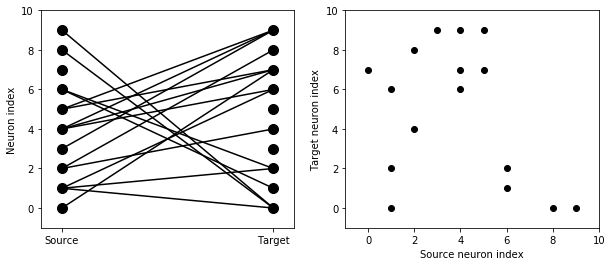

In [4]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
visualise_connectivity(S)

There are two plots here. On the left hand side, you see a vertical line of circles indicating source neurons on the left, and a vertical line indicating target neurons on the right, and a line between two neurons that have a synapse. On the right hand side is another way of visualising the same thing. Here each black dot is a synapse, with x value the source neuron index, and y value the target neuron index.

Let's see how these figures change as we change the probability of a connection:

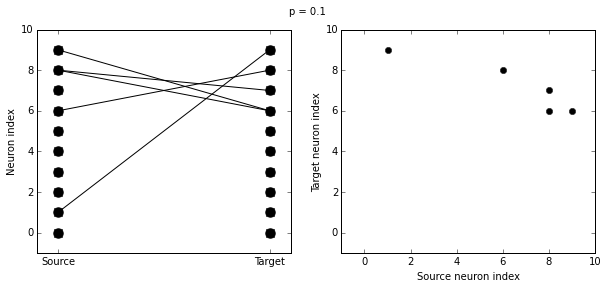

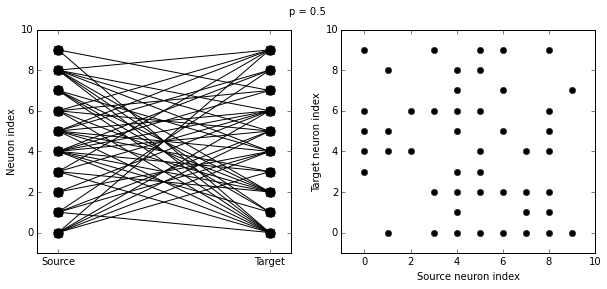

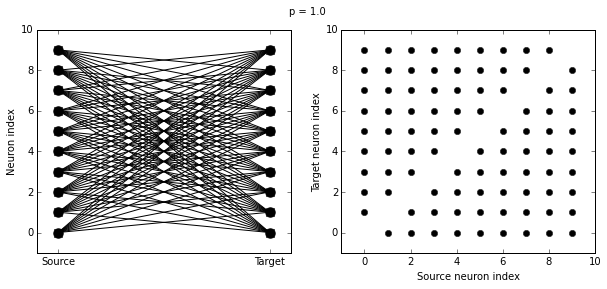

In [7]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))

And let's see what another connectivity condition looks like. This one will only connect neighbouring neurons.

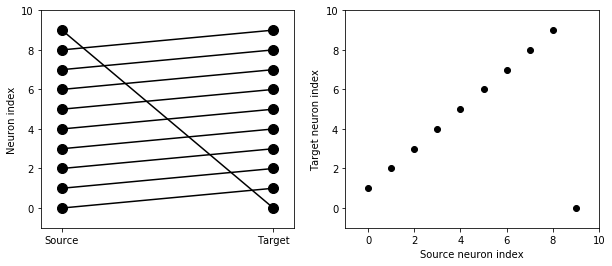

In [10]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='j==(i+1)%10')
visualise_connectivity(S)


Try using that cell to see how other connectivity conditions look like.

You can also use the generator syntax to create connections like this more efficiently. In small examples like this, it doesn't matter, but for large numbers of neurons it can be much more efficient to specify directly which neurons should be connected than to specify just a condition.

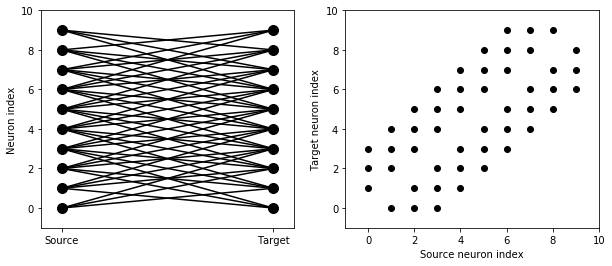

In [5]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='k for k in range(clip(i-3, 0, N_post), clip(i+4, 0, N_post)) if i!=k')
visualise_connectivity(S)

If each source neuron is connected to precisely one target neuron, there is a special syntax that is extremely efficient. For example, 1-to-1 connectivity looks like this:

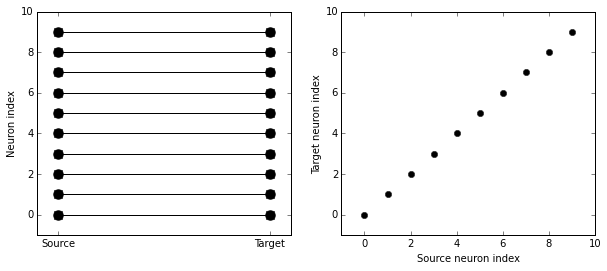

In [10]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='i')
visualise_connectivity(S)

You can also do things like specifying the value of weights with a string. Let's see an example where we assign each neuron a spatial location and have a distance-dependent connectivity function. We visualise the weight of a synapse by the size of the marker.

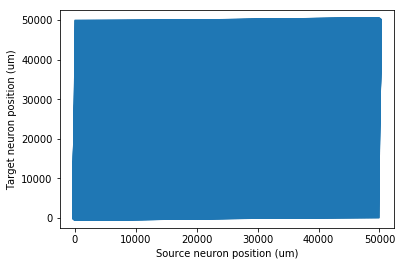

In [7]:
start_scope()

N = 1000
neuron_spacing = 50*umetre
width = N/4.0*neuron_spacing

# Neuron has one variable x, its position
G = NeuronGroup(N, 'x : metre')
G.x = 'i*neuron_spacing'

# All synapses are connected (excluding self-connections)
S = Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')
# Weight varies with distance
S.w = 'exp(-(x_pre-x_post)**2/(2*width**2))'

scatter(G.x[S.i]/um, G.x[S.j]/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)')

Now try changing that function and seeing how the plot changes.

## More complex synapse models: STDP

Brian's synapse framework is very general and can do things like short-term plasticity (STP) or spike-timing dependent plasticity (STDP). Let's see how that works for STDP.

STDP is normally defined by an equation something like this:

$$\Delta w = \sum_{t_{pre}} \sum_{t_{post}} W(t_{post}-t_{pre})$$

That is, the change in synaptic weight w is the sum over all presynaptic spike times $t_{pre}$ and postsynaptic spike times $t_{post}$ of some function $W$ of the difference in these spike times. A commonly used function $W$ is:

$$W(\Delta t) = \begin{cases}
A_{pre} e^{-\Delta t/\tau_{pre}} & \Delta t>0 \\
A_{post}- e^{\Delta t/\tau_{pre}} & \Delta t<0
\end{cases}$$

This function looks like this:

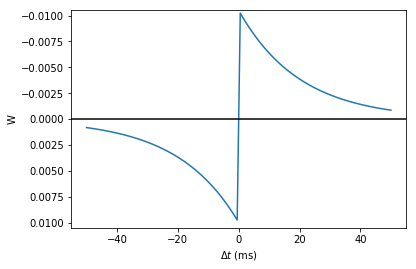

In [8]:
tau_pre = tau_post = 20*ms
A_pre = 0.01
A_post = -A_pre*1.05
delta_t = linspace(-50, 50, 100)*ms
W = where(delta_t<0, A_pre*exp(delta_t/tau_pre), A_post*exp(-delta_t/tau_post))
plot(delta_t/ms, W)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
ylim(-A_post, A_post)
axhline(0, ls='-', c='k')


Simulating it directly using this equation though would be very inefficient, because we would have to sum over all pairs of spikes. That would also be physiologically unrealistic because the neuron cannot remember all its previous spike times. It turns out there is a more efficient and physiologically more plausible way to get the same effect.

We define two new variables $a_{pre}$ and $a_{post}$ which are "traces" of pre- and post-synaptic activity, governed by the differential equations:

$$\begin{eqnarray}
\tau_{pre}\frac{\mathrm{d}}{\mathrm{d}t} a_{pre} &=& -a_{pre}\\
\tau_{post}\frac{\mathrm{d}}{\mathrm{d}t} a_{post} &=& -a_{post}\\
\end{eqnarray}$$

When a presynaptic spike occurs, the presynaptic trace is updated and the weight is modified according to the rule:

$$\begin{eqnarray}
a_{pre} &\rightarrow& a_{pre}+A_{pre}\\
w &\rightarrow& w+a_{post}
\end{eqnarray}$$

When a postsynaptic spike occurs:

$$\begin{eqnarray}
a_{post} &\rightarrow& a_{post}+A_{post}\\
w &\rightarrow& w+a_{pre}
\end{eqnarray}$$

To see that this formulation is equivalent, you just have to check that the equations sum linearly, and consider two cases: what happens if the presynaptic spike occurs before the postsynaptic spike, and vice versa. Try drawing a picture of it.

Now that we have a formulation that relies only on differential equations and spike events, we can turn that into Brian code.

In [13]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(1, 'v:1', threshold='v>1')

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')

There are a few things to see there. Firstly, when defining the synapses we've given a more complicated multi-line string defining three synaptic variables (``w``, ``apre`` and ``apost``). We've also got a new bit of syntax there, ``(event-driven)`` after the definitions of ``apre`` and ``apost``. What this means is that although these two variables evolve continuously over time, Brian should only update them at the time of an event (a spike). This is because we don't need the values of ``apre`` and ``apost`` except at spike times, and it is more efficient to only update them when needed.

Next we have a ``on_pre=...`` argument. The first line is ``v_post += w``: this is the line that actually applies the synaptic weight to the target neuron. The second line is ``apre += Apre`` which encodes the rule above. In the third line, we're also encoding the rule above but we've added one extra feature: we've clamped the synaptic weights between a minimum of 0 and a maximum of ``wmax`` so that the weights can't get too large or negative. The function ``clip(x, low, high)`` does this.

Finally, we have a ``on_post=...`` argument. This gives the statements to calculate when a post-synaptic neuron fires. Note that we do not modify ``v`` in this case, only the synaptic variables.

Now let's see how all the variables behave when a presynaptic spike arrives some time before a postsynaptic spike.

INFO       No numerical integration method specified for group 'neurongroup_2', using method 'linear' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]


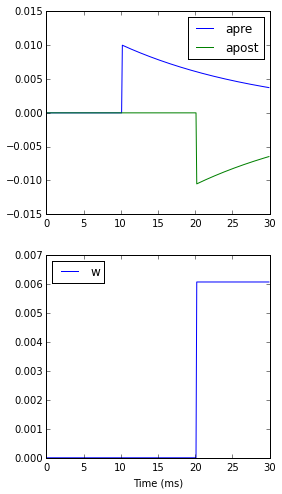

In [14]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend(loc='best')
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)')

A couple of things to note here. First of all, we've used a trick to make neuron 0 fire a spike at time 10 ms, and neuron 1 at time 20 ms. Can you see how that works?

Secondly, we've replaced the ``(event-driven)`` by ``(clock-driven)`` so you can see how ``apre`` and ``apost`` evolve over time. Try reverting this change and see what happens.

Try changing the times of the spikes to see what happens.

Finally, let's verify that this formulation is equivalent to the original one.

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'linear' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'linear' (took 0.00s). [brian2.stateupdaters.base.method_choice]


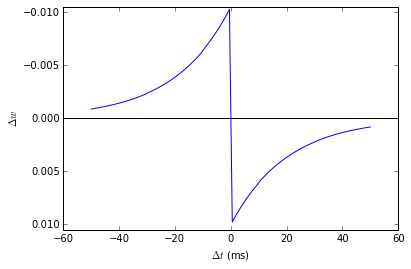

In [15]:
start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(G, H,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             apre += Apre
             w = w+apost
             ''',
             on_post='''
             apost += Apost
             w = w+apre
             ''')
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
ylim(-Apost, Apost)
axhline(0, ls='-', c='k')

Can you see how this works?

## End of tutorial